In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molbloom
import sqlite3
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from IPython.display import display

In [3]:
from aizynthfinder.aizynthfinder import AiZynthFinder

finder = AiZynthFinder("config/config.yml")

In [4]:
finder.stock.selection = 'zinc'
finder.config.expansion_policy.selection = 'uspto'
finder.config.filter_policy.selection = 'uspto'
# finder.config.search.algorithm = "mcts"
# finder.config.scorers.selection = finder.config.scorers.items[0] 

In [5]:
# finder.config.search.algorithm_config["search_rewards"]

In [6]:
finder.config.search.iteration_limit = 1000
finder.config.search.max_transforms = 6
finder.config.search.return_first = True

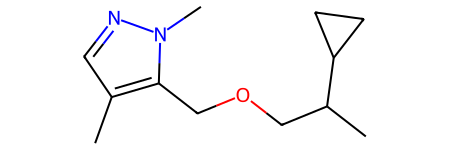

8.78537917137146

In [7]:
smi = 'CC1=NC(CC(=O)N2CCC2(C)C)=C(C)S1'
smi = 'CC(O)(CC1CCCCC1)C1CCCO1'
smi = 'CCC(C#N)C1(O)CCC(C(O)=O)C(C)(C)C1'
smi = 'CC(COCC1=C(C)C=NN1C)C1CC1'
display(Chem.MolFromSmiles(smi))

finder.target_smiles = smi
finder.prepare_tree()
finder.tree_search(show_progress=True)

In [8]:
rewards = finder.config.search.algorithm_config["search_rewards"] 
finder.build_routes(scorer=rewards)
print(len(finder.routes))

5


In [9]:
for route in finder.routes:
    print(route['route_metadata']['is_solved'])

True
False
False
False
False


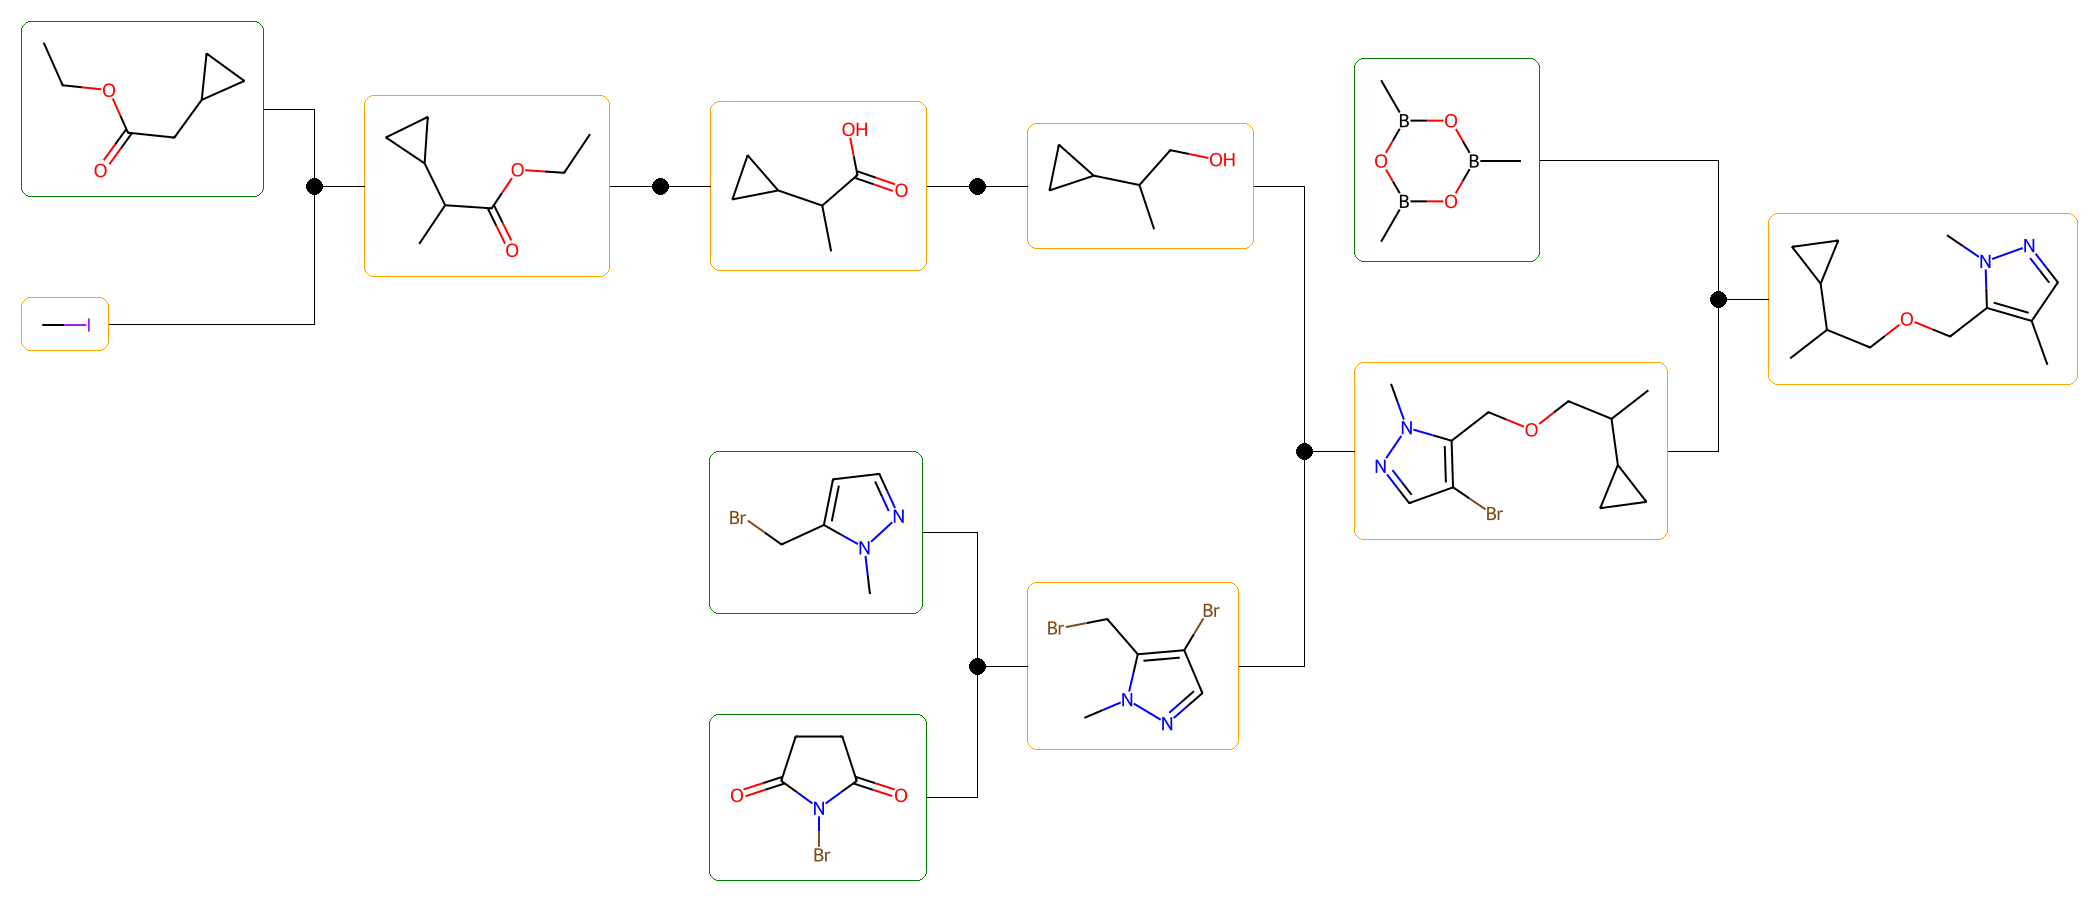

In [10]:
finder.routes[1]['reaction_tree'].to_image()

In [11]:
molbloom.catalogs()

{'zinc20': 'All ZINC20 (1,006,651,037 mols) from Oct 2021. FPR of 0.003. Requires download',
 'zinc-instock': 'ZINC20 instock (9,227,726 mols). FPR of 0.0003. Requires download',
 'zinc-instock-mini': 'ZINC20 instock (9,227,726 mols). FPR of 0.07. Included in package',
 'surechembl': 'SureChEMBL (22,843,364 mols). FPR of 0.000025. Requires download'}

In [12]:
from molbloom import buy

buy('OCC(C1CC1)C', catalog='zinc-instock', canonicalize=True)

False

In [13]:
finder.config.search.time_limit = 120
finder.config.search.iteration_limit = 1000
finder.config.search.max_transforms = 8
finder.config.search.return_first = True

def find_synthetic_route(smiles, show_route=False):
    finder.target_smiles = smiles
    finder.prepare_tree()
    finder.tree_search()
    
    rewards = finder.config.search.algorithm_config["search_rewards"] 
    finder.build_routes(scorer=rewards)
    
    for route in finder.routes:
        if route['route_metadata']['is_solved']:
            if show_route:
                display(route['reaction_tree'].to_image())
            return route
    
    return None

In [14]:
finder.routes[0]

{'reaction_tree': <aizynthfinder.reactiontree.ReactionTree at 0x1dc4530aec0>,
 'route_metadata': {'created_at_iteration': 60, 'is_solved': True},
 'node': <aizynthfinder.search.mcts.node.MctsNode at 0x1dc4535a0e0>,
 'score': {'state score': 0.9865529289315002},
 'all_score': {'state score': 0.9865529289315002}}

In [15]:
reactions = finder.routes[0]['reaction_tree'].reactions()
len(list(reactions))

3

In [16]:
finder.routes[0]['reaction_tree'].reactions()

<generator object ReactionTree.reactions at 0x000001DC450F4970>

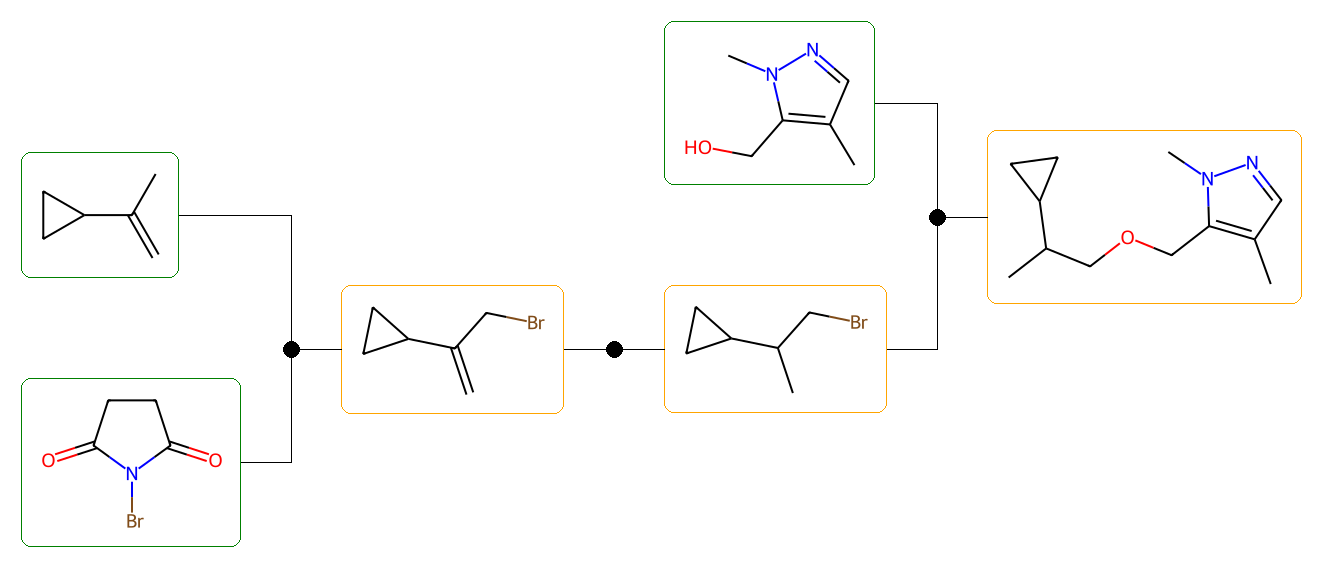

In [17]:
finder.routes[0]['reaction_tree'].to_image()

# Process batch of 1000 random samples from GDB17

In [18]:
with sqlite3.connect('results.db') as conn:
    conn.execute('''
    CREATE TABLE IF NOT EXISTS synthetic_routes (
        id INTEGER PRIMARY KEY,
        smi TEXT NOT NULL,
        solved BOOLEAN,
        num_steps INTEGER,
        score FLOAT,
        tree_dict TEXT
    )
    ''') 

In [19]:
finder.config.search.time_limit = 120
finder.config.search.iteration_limit = 1000
finder.config.search.max_transforms = 8
finder.config.search.return_first = True

# smiles = pd.read_csv('data/rscores_max_2.smi', header=None)
# smiles = pd.read_csv('data/100_rnd.smi', header=None)[0]
smiles = pd.read_csv('data/1000_rnd.smi', header=None)[0]


def smi_exists(smi, conn):
    return conn.execute(f'SELECT EXISTS(SELECT 1 FROM synthetic_routes WHERE smi="{smi}");').fetchall()[0][0]


def write_synthetic_route(smi, route, conn):
    tree_dict = route['reaction_tree'].to_dict()
    score = route['score']['state score']            
    
    reactions = finder.routes[0]['reaction_tree'].reactions()
    num_steps = len(list(reactions))
    sql = f'''
        INSERT INTO synthetic_routes (smi, solved, score, num_steps, tree_dict) 
        VALUES ("{smi}", {solved}, {score}, {num_steps} ,"{tree_dict}")
    '''
    conn.execute(sql)

def write_failed_route(smi, conn):
    sql = f'''
        INSERT INTO synthetic_routes (smi, solved) 
        VALUES ("{smi}", {False})
    '''
    conn.execute(sql)

pbar = tqdm(total=len(smiles), position=0, leave=True)

for smi in smiles:    
    try:
        with (sqlite3.connect('results.db') as conn):            
            if smi_exists(smi, conn):
                pbar.update(1)
                continue
            
            route = find_synthetic_route(smi)
            solved = route is not None
            
            if solved:
                write_synthetic_route(smi, route, conn)
            else:
                write_failed_route(smi, conn)
            pbar.update(1)
            
    except Exception as e:
        print('Exception:', e)

100%|██████████| 1000/1000 [12:13:12<00:00, 120.32s/it] 

In [ ]:
# Test multiprocessing